In [23]:
import pandas as pd
import numpy as np

In [24]:
#preprocessed_df=pd.read_csv('/home/rootuser/arj/ticket/Data/preprocessed_data.csv')
preprocessed_df=pd.read_csv('Data/preprocessed_data.csv')
preprocessed_df.drop(['Unnamed: 0'],1,inplace=True)

In [25]:
preprocessed_df.head()

,Hostname,Application,Utilization(kb),Timestamp
0,vdevice-host-name,dns,0.10,2019-01-18 08:55:00
1,vdevice-host-name,tcp,0.00,2019-01-18 08:55:00
2,vdevice-host-name,https,2.78,2019-01-18 08:55:00
3,vdevice-host-name,google_gen,0.00,2019-01-18 08:55:00
4,vdevice-host-name,firefox_update,0.00,2019-01-18 08:55:00


In [26]:
application_name=['dns','https']

In [27]:
# for i in application_name:
    
df=preprocessed_df.loc[preprocessed_df['Application'] == 'https']
df=df[['Timestamp','Utilization(kb)']]
training_set=df[0:len(df)-150]
print(training_set.shape)
training_set_sliced = training_set.iloc[:, 1:2].values


(15982, 2)


In [28]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set_sliced)


In [29]:
# Creating a data structure with 100 timesteps and 1 output
X_train = []
y_train = []
for i in range(12, len(training_set)):
    X_train.append(training_set_scaled[i-12:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [30]:
X_train.shape

(15970, 12, 1)

In [31]:
y_train.shape

(15970,)

In [32]:

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam , SGD , RMSprop



In [33]:
filepath="stock_weights.hdf5"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

C:\Anaconda3\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [34]:
# # Initialising the RNN
# regressor = Sequential()

# # Adding the first LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 100, activation = 'relu',return_sequences=True,input_shape = (X_train.shape[1], 1)))

# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, activation = 'relu'))
# # Adding the output layer
# regressor.add(Dense(units = 1))
# #regressor.add(Activation("linear"))
# # Compiling the RNN
# #regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
# regressor.compile(loss="mse", optimizer="adam",metrics=['accuracy'])


model = Sequential()
model.add(GRU(256 , input_shape = (X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 12, 256)           198144    
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 739,969
Trainable params: 739,969
Non-trainable params: 0
_________________________________________________________________
None

In [35]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])

In [ ]:

history = model.fit(X_train, y_train, epochs=10 , batch_size = 128 , 
          callbacks = [checkpoint , lr_reduce], shuffle=False,verbose=1 )

In [22]:
# Fitting the RNN to the Training set
# regressor.fit(X_train, y_train, epochs = 50,shuffle=False,verbose=1, batch_size = 16)

In [16]:
# print('model built successfully')
# #regressor.save('/home/rootuser/arj/ticket/model/dns-relu(1000 epo- 100 neuron-288 time).h5') 
model.save('model/new-archi-dns.h5') 

In [17]:

real_pattern_prediction=df[len(df)-150:]

In [18]:
real_pattern_prediction.head()

,Timestamp,Utilization(kb)
592046,2019-03-14 23:40:00,0.61
592095,2019-03-14 23:45:00,0.55
592185,2019-03-14 23:50:00,0.67
592217,2019-03-14 23:55:00,0.64
592261,2019-03-15 00:00:00,1.37


In [19]:
training_set.head()

,Timestamp,Utilization(kb)
0,2019-01-18 08:55:00,0.10
9,2019-01-18 09:00:00,0.21
20,2019-01-18 09:05:00,0.11
21,2019-01-18 09:10:00,0.34
34,2019-01-18 09:15:00,0.14


In [20]:

# Getting the Random predictiond data
dataset_total = pd.concat((training_set['Utilization(kb)'], real_pattern_prediction['Utilization(kb)']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(real_pattern_prediction) - 12:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(12, len(real_pattern_prediction)+12):
    X_test.append(inputs[i-12:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_pattern = model.predict(X_test)
predicted_pattern = sc.inverse_transform(predicted_pattern)

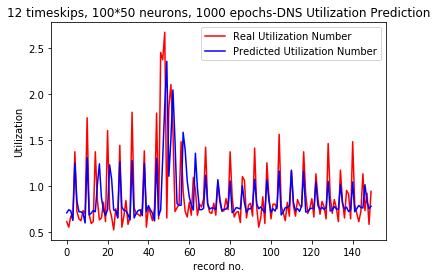

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
real_pattern_prediction=real_pattern_prediction.iloc[:, 1:2].values
# Visualising the results
plt.plot(real_pattern_prediction, color = 'red', label = 'Real Utilization Number')
plt.plot(predicted_pattern, color = 'blue', label = 'Predicted Utilization Number')
plt.title('12 timeskips, 100*50 neurons, 1000 epochs-DNS Utilization Prediction')
plt.xlabel('record no.')
plt.ylabel('Utilization')
plt.legend()
plt.show()

In [40]:

# coding: utf-8

# In[25]:

import pandas as pd
import numpy as np


# In[26]:

preprocessed_df=pd.read_csv('C:/Users/ar393556/Documents/Utilization-prediction-RNN-LSTM/Data/preprocessed_data.csv')
preprocessed_df.drop(['Unnamed: 0'],1,inplace=True)


# In[27]:

preprocessed_df.head()


# In[28]:

application_name=['dns','https']


# In[29]:

# for i in application_name:
    
df=preprocessed_df.loc[preprocessed_df['Application'] == 'dns']
df=df[['Timestamp','Utilization(kb)']]



# In[30]:

df=df[df['Utilization(kb)']!= 0]


# In[31]:

df.shape


# In[32]:

training_set=df[0:len(df)-150]
print(training_set.shape)
training_set_sliced = training_set.iloc[:, 1:2].values


# In[33]:

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set_sliced)


# In[34]:

# Creating a data structure with 100 timesteps and 1 output
X_train = []
y_train = []
for i in range(12, len(training_set)):
    X_train.append(training_set_scaled[i-12:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


# In[35]:


# Importing the Keras libraries and packages

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam , SGD , RMSprop

filepath="stock_weights.hdf5"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

# Initialising the RNN
regressor = Sequential()


# In[36]:

model = Sequential()
model.add(GRU(256 , input_shape = (X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dropout(0.3))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))
print(model.summary())

model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['accuracy'])


history = model.fit(X_train, y_train, epochs=1 , batch_size = 128 , 
          callbacks = [checkpoint , lr_reduce], shuffle=False,verbose=1 )




# In[98]:

print('model built successfully')
model.save('C:/Users/ar393556/Documents/Utilization-prediction-RNN-LSTM/model/new-dns-fine-tuning-task-scheduler.h5') 



print('model built successfully')


(15978, 2)


C:\Anaconda3\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 12, 256)           198144    
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 739,969
Trainable params: 739,969
Non-trainable params: 0
_________________________________________________________________
None

C:\Anaconda3\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
C:\Anaconda3\lib\site-packages\keras\callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


model built successfully
